# Kom i gang med DAT801-2021-konkurransen

***UNDER CONSTRUCTION***


Denne notebooken beskriver hvordan du kan:
1. Laste inn data: vi bruker Pandas til å laste inn trenings- og test-data
2. Undersøke features: vi undersøker et par features via statistikk og enkle plots.
3. Submitte dine prediksjoner for scoring (og plassering på leaderboard): etter at du har laget en modell og produsert prediksjoner på testdata så må du samle disse i en fil som Kaggle kan bruke til scoring. 


# Setup

In [1378]:
%matplotlib inline
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression #Best accuracy.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipeline
from sklearn.model_selectionction import train_test_split

# Last inn data

In [1379]:
NB_DIR = Path.cwd()
DATA = NB_DIR/'data'
DATA.mkdir(exist_ok=True)

In [1380]:
train = pd.read_csv(DATA/'train.csv')
test = pd.read_csv(DATA/'test.csv')
sampleSubmission = pd.read_csv(DATA/'sample_submission.csv')

In [1381]:
corr = train.corr() #Sjekker korrelasjon mellom features for å eventuelt selektere bort features.
corr.style.background_gradient(cmap='coolwarm', axis=None)

,id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,target
id,1.000000,0.002684,0.002005,0.009581,0.000741,0.002826,0.001006,0.003538,-0.000294,0.002665,0.002916,-0.000401,-0.000665,0.000245,0.001698,0.001380,-0.001819,0.005829,0.002010,-0.000999,0.001906,-0.000336,0.003121,-0.001065,-0.003047,0.000260,-0.000868,0.006572,0.000149,0.000804,0.000918,-0.000200,0.001491,0.004780,0.002905,-0.000115,-0.000612,-0.002696,-0.001214,0.001205,-0.001415,-0.004630,0.000105,0.001047,0.002749,0.000806,-0.003501,0.003758,0.002259,-0.000602,0.003069,-0.005442,0.002669,0.004339,-0.000449,0.004044,0.000577,0.000485,0.000793,0.002646,-0.002740,0.004652,-0.001590,0.004301,0.000781,-0.002282,0.000960,0.004685,-0.000092,-0.000929,0.002502,-0.000204,0.002784,0.001151,0.001434,-0.002775,0.003219
f_0,0.002684,1.000000,0.077131,0.069192,0.070853,0.071443,0.064661,0.067538,0.068584,0.067296,0.075376,0.073372,0.062498,0.067214,0.072476,0.083064,0.068834,0.086371,0.031303,0.078101,0.063688,0.049288,0.061860,0.051035,0.054281,0.066706,0.057861,0.065360,0.058678,0.068055,0.081081,0.073449,0.080261,0.065144,0.064231,0.060894,0.073042,0.057841,0.072039,0.065717,0.071291,0.057046,0.067021,0.068731,0.076387,0.076644,0.076620,0.083968,0.063300,0.076438,0.039777,0.066992,0.076245,0.073697,0.070307,0.072590,0.090896,0.078069,0.063413,0.064021,0.059679,0.063256,0.069246,0.079411,0.070998,0.071812,0.073543,0.048753,0.076777,0.061234,0.065406,0.081409,0.056070,0.058614,0.074361,0.054747,0.042415
f_1,0.002005,0.077131,1.000000,0.097276,0.094829,0.094090,0.068338,0.077574,0.084071,0.091351,0.086932,0.066225,0.055324,0.103460,0.084786,0.109024,0.074045,0.104669,0.031936,0.108583,0.076686,0.044832,0.082828,0.063044,0.072148,0.067832,0.065771,0.059165,0.060832,0.090722,0.080055,0.085903,0.101340,0.080908,0.065605,0.075615,0.081285,0.058676,0.104819,0.092062,0.067186,0.081777,0.082851,0.065528,0.099461,0.102812,0.091792,0.082930,0.071888,0.088435,0.067854,0.088190,0.077062,0.089580,0.102277,0.078735,0.099112,0.096303,0.058517,0.085397,0.066364,0.078370,0.081485,0.090405,0.090225,0.088667,0.097788,0.076117,0.090445,0.061784,0.066698,0.088123,0.059480,0.081982,0.095878,0.068579,0.060766
f_2,0.009581,0.069192,0.097276,1.000000,0.094813,0.085639,0.070192,0.075649,0.090670,0.097850,0.083204,0.063297,0.060794,0.104456,0.087832,0.106870,0.077166,0.104228,0.051485,0.120112,0.074999,0.045136,0.089958,0.075318,0.087561,0.074785,0.066276,0.054873,0.067965,0.088908,0.084814,0.079804,0.107773,0.079786,0.072680,0.067500,0.081861,0.065834,0.106899,0.090138,0.073227,0.079654,0.077836,0.064909,0.099819,0.094973,0.082505,0.089885,0.069423,0.089984,0.067781,0.088756,0.075764,0.079052,0.109054,0.087796,0.104083,0.094902,0.062826,0.083911,0.068210,0.081440,0.074747,0.086793,0.088309,0.084321,0.100980,0.074841,0.095147,0.066170,0.060647,0.078604,0.059289,0.089133,0.088216,0.062060,0.058548
f_3,0.000741,0.070853,0.094829,0.094813,1.000000,0.085314,0.071503,0.082415,0.083907,0.095900,0.092353,0.062974,0.061495,0.099768,0.080123,0.101509,0.085576,0.104115,0.050744,0.107873,0.074080,0.044987,0.087135,0.079562,0.072199,0.077527,0.074979,0.061644,0.058945,0.100961,0.084139,0.075804,0.096902,0.078497,0.074319,0.073711,0.088126,0.070718,0.108237,0.093660,0.072677,0.084010,0.086449,0.074929,0.093108,0.105540,0.090028,0.087051,0.080918,0.097565,0.064965,0.082119,0.082508,0.075180,0.105157,0.094565,0.102685,0.098752,0.069025,0.085347,0.068401,0.081918,0.076907,0.092888,0.084947,0.085422,0.096090,0.084628,0.088186,0.080896,0.067653,0.079729,0.062440,0.084790,0.098143,0.061896,0.059881
f_4,0.002826,0.071443,0.094090,0.085639,0.085314,1.000000,0.080556,0.075512,0.083583,0.079374,0.091090,0.074290,0

In [947]:
#Denne funksjonen fjerner features med korrelasjon over angitt tersel.

def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    print(drops)
    x = x.drop(columns=drops, inplace=True)

    return x

In [949]:
remove_collinear_features(train, 0.12) #kaller på funksjonen over med en terskel på korrelasjon over 0.12

f_14 | f_12 | 0.13
f_16 | f_14 | 0.12
f_18 | f_2 | 0.12
f_18 | f_8 | 0.13
f_18 | f_12 | 0.14
f_18 | f_14 | 0.13
f_18 | f_16 | 0.13
f_31 | f_16 | 0.12
f_31 | f_18 | 0.14
f_37 | f_12 | 0.13
f_37 | f_14 | 0.12
f_37 | f_16 | 0.12
f_37 | f_18 | 0.14
f_37 | f_31 | 0.12
f_43 | f_12 | 0.12
f_43 | f_18 | 0.13
f_44 | f_14 | 0.12
f_44 | f_16 | 0.13
f_44 | f_18 | 0.13
f_53 | f_14 | 0.12
f_53 | f_18 | 0.13
f_53 | f_37 | 0.12
f_56 | f_16 | 0.12
f_56 | f_18 | 0.13
{'f_44', 'f_56', 'f_14', 'f_37', 'f_43', 'f_53', 'f_31', 'f_16', 'f_18'}


In [1324]:
corr_matrix = train.corr()
print(corr_matrix["target"].sort_values(ascending=False)) #printer korrelasjon mellom features og target.

target    1.000000
f_18      0.110805
f_12      0.098610
f_16      0.090865
f_37      0.088362
            ...   
f_71      0.016525
f_17      0.013303
f_11      0.007447
id        0.003219
f_20     -0.000144
Name: target, Length: 77, dtype: float64


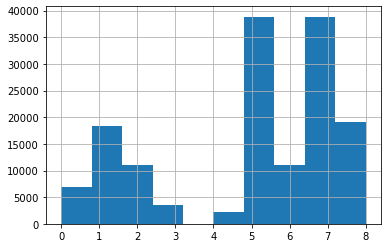

In [1382]:
train["target"].hist() #hvilke target har høyest representasjon.
plt.show()

In [1470]:
X_train, y_train = train.drop(["target", "id"], axis=1), train.target

In [1543]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 42, stratify=y)

# Ta en titt på data

In [1544]:
X_train.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74
91116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0
6625,2.0,0.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,...,17.0,0.0,0.0,0.0,1.0,0.0,16.0,0.0,0.0,0.0
68695,0.0,0.0,1.0,0.0,3.0,2.0,0.0,3.0,1.0,3.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0
37609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,NaN,0.0,6.0,1.0,0.0,2.0,0.0,0.0,0.0


In [1545]:
X_train.describe()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74
count,88200.000000,89115.000000,89553.000000,89562.000000,89100.000000,89550.000000,88143.000000,88197.000000,89552.000000,89120.000000,...,89544.000000,88196.000000,89560.000000,89082.000000,89537.000000,89087.000000,88208.000000,88152.000000,89096.000000,89112.000000
mean,0.981134,1.195422,2.198966,2.302595,0.785713,1.417822,1.021681,0.671315,1.943128,1.697655,...,1.800042,0.507880,1.818680,0.924317,1.595017,1.203632,0.802501,1.277362,2.930985,0.631262
std,3.935858,4.090949,6.403601,7.580934,2.896734,5.129359,3.989008,2.254381,3.921810,5.836273,...,5.067216,1.846381,7.142949,3.894158,4.840860,4.753928,2.434011,4.237381,10.754003,3.913940
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,61.000000,51.000000,64.000000,70.000000,38.000000,76.000000,43.000000,30.000000,38.000000,72.000000,...,54.000000,24.000000,79.000000,55.000000,65.000000,67.000000,30.000000,61.000000,130.000000,52.000000


In [1546]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90000 entries, 91116 to 104025
Data columns (total 75 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_0     88200 non-null  float64
 1   f_1     89115 non-null  float64
 2   f_2     89553 non-null  float64
 3   f_3     89562 non-null  float64
 4   f_4     89100 non-null  float64
 5   f_5     89550 non-null  float64
 6   f_6     88143 non-null  float64
 7   f_7     88197 non-null  float64
 8   f_8     89552 non-null  float64
 9   f_9     89120 non-null  float64
 10  f_10    89098 non-null  float64
 11  f_11    89086 non-null  float64
 12  f_12    89101 non-null  float64
 13  f_13    89091 non-null  float64
 14  f_14    89541 non-null  float64
 15  f_15    88247 non-null  float64
 16  f_16    89541 non-null  float64
 17  f_17    89101 non-null  float64
 18  f_18    89084 non-null  float64
 19  f_19    89111 non-null  float64
 20  f_20    89095 non-null  float64
 21  f_21    88252 non-null  float6

In [1547]:
X_train.shape #sjekker at features over terskel har blitt droppet, og at vi har like mange samples som før.

(90000, 75)

In [1548]:
y_train.shape

(90000,)

In [1549]:
X_test.shape

(60000, 75)

In [1550]:
y_test.shape

(60000,)

In [1551]:
X_train[:10] # ser på de 10 første radene i datasettet. 

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74
91116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0
6625,2.0,0.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,...,17.0,0.0,0.0,0.0,1.0,0.0,16.0,0.0,0.0,0.0
68695,0.0,0.0,1.0,0.0,3.0,2.0,0.0,3.0,1.0,3.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0
37609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,NaN,0.0,6.0,1.0,0.0,2.0,0.0,0.0,0.0
52250,0.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,4.0,0.0,7.0,0.0,0.0
139529,0.0,2.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
7246,2.0,0.0,0.0,3.0,0.0,23.0,0.0,6.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,5.0,0.0
78796,7.0,0.0,0.0,0.0,0.0,1.0,14.0,NaN,6.0,1.0,...,33.0,0.0,1.0,3.0,0.0,1.0,10.0,4.0,0.0,0.0
83887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0


In [1552]:
imp = SimpleImputer(strategy = "median") #Erstatter NaN verdier i datasettet ved å imputere mean verdier.

In [1553]:
X_train_imputed = imp.fit_transform(X_train)

In [1554]:
X_test_imputed = imp.transform(X_test)

In [1555]:
#X_train_imputed = X_train_imputed.astype("int64") # Tallene i test er heltall, så det er naturlig å omforme dette fra float til int.

In [1556]:
X_train_imputed[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  2.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  3.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  5.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [1557]:
std = StandardScaler()

In [1558]:
mms = MinMaxScaler()

In [1559]:
X_train_std = std.fit_transform(X_train_imputed)

In [1560]:
X_train_std = pd.DataFrame(data=X_train_std,columns=X_train.columns )

In [1561]:
X_test_std = std.transform(X_test_imputed)

In [1562]:
X_train_std.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74
0,-0.246624,-0.290651,-0.342443,-0.302929,-0.269784,-0.275670,-0.253298,-0.294525,2.060734,-0.289336,...,-0.354221,-0.272092,-0.25395,0.021962,-0.328552,-0.251819,-0.326053,-0.298064,-0.271076,-0.160468
1,0.266368,-0.290651,-0.342443,-0.038523,0.077046,-0.275670,0.252994,-0.294525,-0.493934,-0.289336,...,3.008154,-0.272092,-0.25395,-0.236080,-0.121500,-0.251819,6.306759,-0.298064,-0.271076,-0.160468
2,-0.246624,-0.290651,-0.185937,-0.302929,0.770706,0.115148,-0.253298,1.048566,-0.238467,0.227011,...,-0.156434,-0.272092,-0.11363,-0.236080,-0.328552,-0.251819,-0.326053,0.416641,0.009198,-0.160468
3,-0.246624,-0.290651,-0.342443,-0.302929,-0.269784,-0.275670,-0.253298,-0.294525,-0.493934,-0.289336,...,-0.354221,-0.272092,-0.25395,-0.236080,-0.328552,-0.251819,-0.326053,-0.298064,-0.271076,-0.160468
4,-0.246624,-0.290651,-0.342443,-0.302929,-0.269784,-0.275670,-0.253298,-0.294525,-0.493934,-0.289336,...,0.436926,-0.272092,-0.25395,1.312172,-0.121500,-0.251819,0.503048,-0.298064,-0.271076,-0.160468


In [1563]:
X_train_std.describe()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74
count,9.000000e+04,9.000000e+04,9.000000e+04,9.000000e+04,9.000000e+04,9.000000e+04,9.000000e+04,9.000000e+04,9.000000e+04,9.000000e+04,...,9.000000e+04,9.000000e+04,9.000000e+04,9.000000e+04,9.000000e+04,9.000000e+04,9.000000e+04,9.000000e+04,9.000000e+04,9.000000e+04
mean,-4.339467e-16,3.561568e-15,1.175368e-15,-1.762043e-15,5.316334e-15,2.432517e-15,1.841582e-15,2.165811e-16,-6.293854e-17,-1.975526e-15,...,1.148147e-15,1.467467e-15,-1.403764e-15,-1.005953e-15,-6.244234e-16,1.161530e-15,7.840728e-16,4.539067e-16,-8.900426e-16,-8.485126e-16
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,...,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-2.466236e-01,-2.906507e-01,-3.424430e-01,-3.029287e-01,-2.697836e-01,-2.756702e-01,-2.532980e-01,-2.945248e-01,-4.939335e-01,-2.893364e-01,...,-3.542207e-01,-2.720925e-01,-2.539500e-01,-2.360798e-01,-3.285518e-01,-2.518190e-01,-3.260534e-01,-2.980636e-01,-2.710764e-01,-1.604682e-01
25%,-2.466236e-01,-2.906507e-01,-3.424430e-01,-3.029287e-01,-2.697836e-01,-2.756702e-01,-2.532980e-01,-2.945248e-01,-4.939335e-01,-2.893364e-01,...,-3.542207e-01,-2.720925e-01,-2.539500e-01,-2.360798e-01,-3.285518e-01,-2.518190e-01,-3.260534e-01,-2.980636e-01,-2.710764e-01,-1.604682e-01
50%,-2.466236e-01,-2.906507e-01,-3.424430e-01,-3.029287e-01,-2.697836e-01,-2.756702e-01,-2.532980e-01,-2.945248e-01,-4.939335e-01,-2.893364e-01,...,-3.542207e-01,-2.720925e-01,-2.539500e-01,-2.360798e-01,-3.285518e-01,-2.518190e-01,-3.260534e-01,-2.980636e-01,-2.710764e-01,-1.604682e-01
75%,9.872240e-03,-4.509956e-02,-1.859366e-01,-1.707256e-01,-2.697836e-01,-8.026105e-02,-2.532980e-01,-2.945248e-01,1.699989e-02,-1.172205e-01,...,-1.564339e-01,-2.720925e-01,-1.136298e-01,2.196224e-02,8.555143e-02,-4.045899e-02,8.849737e-02,-5.982871e-02,-1.776515e-01,-1.604682e-01
max,1.539962e+01,1.223246e+01,9.673969e+00,8.951288e+00,1.290975e+01,1.457542e+01,1.063198e+01,1.313638e+01,9.213802e+00,1.210301e+01,...,1.032626e+01,1.284870e+01,1.083135e+01,1.395623e+01,1.312980e+01,1.390930e+01,1.211047e+01,1.423426e+01,1.187416e+01,1.318977e+01


In [1564]:
X_train_std.iloc[0]

f_0    -0.246624
f_1    -0.290651
f_2    -0.342443
f_3    -0.302929
f_4    -0.269784
          ...   
f_70   -0.251819
f_71   -0.326053
f_72   -0.298064
f_73   -0.271076
f_74   -0.160468
Name: 0, Length: 75, dtype: float64

In [1565]:
X_train_mms = mms.fit_transform(X_train_imputed)

In [1566]:
X_train_mms = pd.DataFrame(data=X_train_mms,columns=X_train.columns )

In [1567]:
X_test_mms = mms.transform(X_test_imputed)

In [1568]:
X_train_mms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 75 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_0     90000 non-null  float64
 1   f_1     90000 non-null  float64
 2   f_2     90000 non-null  float64
 3   f_3     90000 non-null  float64
 4   f_4     90000 non-null  float64
 5   f_5     90000 non-null  float64
 6   f_6     90000 non-null  float64
 7   f_7     90000 non-null  float64
 8   f_8     90000 non-null  float64
 9   f_9     90000 non-null  float64
 10  f_10    90000 non-null  float64
 11  f_11    90000 non-null  float64
 12  f_12    90000 non-null  float64
 13  f_13    90000 non-null  float64
 14  f_14    90000 non-null  float64
 15  f_15    90000 non-null  float64
 16  f_16    90000 non-null  float64
 17  f_17    90000 non-null  float64
 18  f_18    90000 non-null  float64
 19  f_19    90000 non-null  float64
 20  f_20    90000 non-null  float64
 21  f_21    90000 non-null  float64
 22

In [1569]:
param_grid = {"n_estimators": [800],
             "max_depth": [5, 7],
             "max_features": [5, 6]}

In [1596]:
rf = RandomForestClassifier(n_estimators = 800,max_depth = 7, max_features= 5, n_jobs=-1)

In [1597]:
rf.fit(X_train_std, y_train)

RandomForestClassifier(max_depth=7, max_features=5, n_estimators=800, n_jobs=-1)

In [1598]:
rf.predict(X_test_std)

array([7, 7, 7, 5, 5, 5, 7, 7, 7, 5, 1, 7, 5, 7, 7, 5, 7, 7, 5, 1, 5, 5,
       7, 7, 7, 7, 5, 7, 5, 7, 5, 7, 5, 5, 7, 1, 7, 7, 5, 5, 7, 7, 1, 7,
       5, 5, 5, 7, 5, 7, 7, 7, 5, 1, 7, 7, 5, 7, 7, 7, 7, 1, 5, 5, 7, 5,
       5, 5, 7, 7, 7, 7, 5, 7, 1, 7, 7, 1, 5, 7, 1, 5, 7, 7, 1, 7, 7, 7,
       7, 1, 7, 7, 7, 7, 7, 5, 1, 5, 5, 7, 5, 5, 7, 5, 5, 7, 1, 5, 7, 7,
       7, 5, 7, 5, 7, 7, 7, 7, 7, 7, 7, 5, 7, 1, 1, 7, 5, 5, 5, 5, 1, 7,
       5, 7, 1, 1, 1, 7, 1, 7, 5, 5, 5, 1, 7, 5, 1, 7, 7, 7, 5, 7, 5, 5,
       1, 5, 7, 1, 5, 1, 7, 5, 7, 7, 7, 7, 7, 1, 1, 1, 7, 7, 5, 5, 7, 7,
       7, 7, 7, 5, 5, 1, 7, 7, 7, 7, 7, 1, 7, 7, 1, 7, 5, 7, 1, 7, 1, 1,
       7, 5, 7, 7, 7, 5, 7, 7, 5, 7, 5, 5, 7, 7, 7, 7, 7, 1, 5, 1, 7, 5,
       7, 5, 5, 7, 1, 1, 5, 5, 7, 7, 7, 1, 7, 7, 1, 7, 1, 5, 1, 5, 7, 5,
       7, 1, 7, 1, 7, 7, 7, 5, 5, 1, 5, 7, 1, 5, 1, 5, 7, 7, 1, 7, 5, 7,
       1, 5, 7, 7, 5, 5, 7, 1, 1, 1, 7, 5, 7, 1, 7, 7, 5, 5, 7, 7, 1, 7,
       7, 5, 7, 7, 1, 7, 7, 7, 7, 5, 5, 5, 1, 1, 7,

In [1599]:
kaggle_test = test.drop("id", axis=1)

In [1601]:
kaggle_test_std= std.transform(kaggle_test)

In [ ]:
kaggle_test_std

In [1602]:
#gs_reg = GridSearchCV(estimator=rf, param_grid = param_grid, cv=3, verbose=1, n_jobs=-1)

In [1603]:
rf.predict(kaggle_test)

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [1572]:
#gs_reg.fit(X_train_std, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 7], 'max_features': [5, 6],
                         'n_estimators': [800]},
             verbose=1)

In [1605]:
X_test_std.info()

AttributeError: 'numpy.ndarray' object has no attribute 'info'

In [1573]:
#best_reg = gs_reg.best_estimator_

In [1574]:
#best_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 5,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [1576]:
kaggle_test

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74
0,0,0,10,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,6,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2,0,1,2,1,1,2,0,1,...,4,0,1,1,0,1,1,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,3,0,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,0,0,0,0,2,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
49996,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,3,0,1,0,0,0
49997,4,6,1,4,1,3,0,3,2,8,...,4,2,0,1,1,3,2,3,0,1
49998,0,1,0,2,3,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [1580]:
y_pred_best = best_reg.predict(X_test_std)

In [1583]:
y_pred_best

array([7, 7, 7, 5, 5, 5, 7, 7, 7, 5, 1, 7, 5, 7, 7, 5, 7, 7, 5, 1, 5, 5,
       7, 7, 7, 7, 5, 7, 5, 7, 5, 7, 5, 5, 7, 1, 7, 5, 5, 5, 7, 7, 1, 7,
       5, 5, 5, 7, 5, 7, 7, 7, 5, 1, 7, 7, 5, 7, 7, 7, 7, 1, 5, 5, 7, 5,
       5, 5, 7, 7, 7, 7, 7, 7, 1, 7, 7, 1, 5, 7, 1, 5, 7, 7, 1, 7, 7, 5,
       5, 1, 7, 7, 7, 7, 7, 5, 1, 5, 5, 7, 5, 5, 7, 5, 5, 7, 1, 5, 7, 7,
       7, 5, 7, 5, 7, 7, 5, 7, 7, 7, 7, 5, 7, 1, 1, 7, 5, 5, 5, 7, 1, 7,
       5, 7, 1, 1, 1, 7, 1, 7, 5, 5, 5, 1, 7, 5, 1, 5, 7, 7, 5, 7, 5, 5,
       1, 5, 7, 1, 7, 1, 7, 5, 7, 7, 7, 7, 7, 1, 1, 1, 7, 7, 5, 5, 7, 7,
       7, 7, 7, 5, 5, 1, 7, 7, 7, 7, 7, 1, 7, 7, 1, 7, 5, 7, 1, 7, 1, 1,
       7, 5, 7, 7, 7, 5, 7, 7, 5, 7, 5, 5, 7, 7, 7, 7, 7, 1, 5, 1, 7, 5,
       7, 5, 5, 7, 1, 1, 5, 5, 7, 7, 7, 1, 7, 7, 1, 7, 1, 5, 1, 7, 7, 5,
       7, 1, 7, 1, 7, 7, 7, 5, 5, 1, 5, 7, 1, 5, 1, 5, 7, 7, 1, 7, 5, 7,
       1, 5, 7, 7, 5, 7, 7, 1, 1, 1, 7, 5, 7, 1, 7, 7, 5, 5, 7, 7, 1, 7,
       7, 5, 7, 7, 1, 7, 7, 7, 7, 5, 5, 5, 1, 1, 7,

In [1584]:
np.info(y_pred_best)

class:  ndarray
shape:  (60000,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x21b2f9ef040
byteorder:  little
byteswap:  False
type: int64


In [1585]:
np.set_printoptions(threshold=np.inf)

In [1586]:
print(y_pred_best)

[7 7 7 5 5 5 7 7 7 5 1 7 5 7 7 5 7 7 5 1 5 5 7 7 7 7 5 7 5 7 5 7 5 5 7 1 7
 5 5 5 7 7 1 7 5 5 5 7 5 7 7 7 5 1 7 7 5 7 7 7 7 1 5 5 7 5 5 5 7 7 7 7 7 7
 1 7 7 1 5 7 1 5 7 7 1 7 7 5 5 1 7 7 7 7 7 5 1 5 5 7 5 5 7 5 5 7 1 5 7 7 7
 5 7 5 7 7 5 7 7 7 7 5 7 1 1 7 5 5 5 7 1 7 5 7 1 1 1 7 1 7 5 5 5 1 7 5 1 5
 7 7 5 7 5 5 1 5 7 1 7 1 7 5 7 7 7 7 7 1 1 1 7 7 5 5 7 7 7 7 7 5 5 1 7 7 7
 7 7 1 7 7 1 7 5 7 1 7 1 1 7 5 7 7 7 5 7 7 5 7 5 5 7 7 7 7 7 1 5 1 7 5 7 5
 5 7 1 1 5 5 7 7 7 1 7 7 1 7 1 5 1 7 7 5 7 1 7 1 7 7 7 5 5 1 5 7 1 5 1 5 7
 7 1 7 5 7 1 5 7 7 5 7 7 1 1 1 7 5 7 1 7 7 5 5 7 7 1 7 7 5 7 7 1 7 7 7 7 5
 5 5 1 1 7 5 1 7 5 5 5 7 7 7 7 7 7 7 5 5 5 7 1 5 7 5 5 7 5 1 7 7 5 1 7 1 5
 7 7 1 7 1 5 1 7 7 5 5 7 5 1 1 7 1 5 7 7 7 5 7 7 7 5 7 7 7 7 1 1 5 5 7 7 7
 7 1 1 1 7 7 7 1 7 5 7 7 7 1 1 1 7 1 5 7 7 7 5 5 7 5 7 7 5 7 5 1 7 7 5 5 7
 7 5 5 5 7 5 7 7 7 1 1 7 5 5 7 5 7 7 5 5 7 5 1 7 7 5 7 5 1 7 7 7 5 7 5 7 7
 5 5 7 7 7 7 5 5 7 5 1 5 1 7 5 7 7 5 5 7 7 5 5 7 7 1 7 7 5 5 5 5 7 7 7 1 7
 7 7 5 5 5 7 5 7 5 1 5 7 

In [1587]:
np.info(y_pred_best)

class:  ndarray
shape:  (60000,)
strides:  (8,)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x21b2f9ef040
byteorder:  little
byteswap:  False
type: int64


In [1588]:
y_pred_best

array([7, 7, 7, 5, 5, 5, 7, 7, 7, 5, 1, 7, 5, 7, 7, 5, 7, 7, 5, 1, 5, 5,
       7, 7, 7, 7, 5, 7, 5, 7, 5, 7, 5, 5, 7, 1, 7, 5, 5, 5, 7, 7, 1, 7,
       5, 5, 5, 7, 5, 7, 7, 7, 5, 1, 7, 7, 5, 7, 7, 7, 7, 1, 5, 5, 7, 5,
       5, 5, 7, 7, 7, 7, 7, 7, 1, 7, 7, 1, 5, 7, 1, 5, 7, 7, 1, 7, 7, 5,
       5, 1, 7, 7, 7, 7, 7, 5, 1, 5, 5, 7, 5, 5, 7, 5, 5, 7, 1, 5, 7, 7,
       7, 5, 7, 5, 7, 7, 5, 7, 7, 7, 7, 5, 7, 1, 1, 7, 5, 5, 5, 7, 1, 7,
       5, 7, 1, 1, 1, 7, 1, 7, 5, 5, 5, 1, 7, 5, 1, 5, 7, 7, 5, 7, 5, 5,
       1, 5, 7, 1, 7, 1, 7, 5, 7, 7, 7, 7, 7, 1, 1, 1, 7, 7, 5, 5, 7, 7,
       7, 7, 7, 5, 5, 1, 7, 7, 7, 7, 7, 1, 7, 7, 1, 7, 5, 7, 1, 7, 1, 1,
       7, 5, 7, 7, 7, 5, 7, 7, 5, 7, 5, 5, 7, 7, 7, 7, 7, 1, 5, 1, 7, 5,
       7, 5, 5, 7, 1, 1, 5, 5, 7, 7, 7, 1, 7, 7, 1, 7, 1, 5, 1, 7, 7, 5,
       7, 1, 7, 1, 7, 7, 7, 5, 5, 1, 5, 7, 1, 5, 1, 5, 7, 7, 1, 7, 5, 7,
       1, 5, 7, 7, 5, 7, 7, 1, 1, 1, 7, 5, 7, 1, 7, 7, 5, 5, 7, 7, 1, 7,
       7, 5, 7, 7, 1, 7, 7, 7, 7, 5, 5, 5, 1, 1, 7,

In [1459]:
list(zip(y_test, y_pred_best))[:10]

[(5, 7),
 (1, 7),
 (0, 7),
 (7, 7),
 (7, 7),
 (7, 7),
 (5, 7),
 (5, 7),
 (7, 7),
 (8, 7)]

In [1460]:
accuracy_score(y_test, y_pred_best)

ValueError: Found input variables with inconsistent numbers of samples: [37500, 50000]

Det er 50.000 test-instanser, og det ser ikke ut til å mangle noen features. 

# Utforsk data, preprosesser data, utforsk modeller ("model selection"), prediker & evaluer

Jeg overlater disse delene til dere. Du bør utforske features via statistikk og plots, forsøke å avdekke sammenhenger mellom features og mellom features og labels ved å undersøke korrelasjoner og lignende, og gjerne forsøke å konstruere nye features ved å kombinere eksisterende. Før du kan trene modeller må du sørge for at data er på en egnet form. Du må blant annet finne ut hvordan du best kan takle manglende verdier ("missing values"). Husk å designe et grundig evalueringsoppsett som du kan bruke underveis i utforskingen av modeller. Kryss-validering er naturlig. Bør du kanskje vurdere stratifisert splitting i trening- og validerings-data? Hva med ensembling av flere modeller?

Hva må være med her:

Det bør plottes i ulike plots for å se på dataene etter det er optimalisert/utfylt.
Kan features kombineres eller optimaliseres?

Data må insertes med median verdi for manglende verdier (simpleimputer). Dette fordi alle tall i datasettet er heltall, og det gir feil output om jeg bruker mean som vil gi flyttallverdier. Senere kan jeg vurdere om jeg får tid til å sample opp mer data for å kunne gi forbedret score ved å få opp verdiene i de klassene som er minst hyppig. 

Jeg bør bruke en scaler for å normalisere data. Min/Max scaler ga best verdi. Kan teste med flere. 


Modellene jeg vil teste med er LogisticRegression, Randomforrest(100 trær), SGDClassifier, KNeighbors.
Jeg må bruke gridsearch for å finne optimalisert verdi, og Cross-validation over hele treningssettet. 
Tenker at jeg bør ha med Pipeline her for å få alt strømlinjeformet. Modellen må trenes med de ulike modellene, før man kan predicte og sammenligne. #rf_clf = RandomForestClassifier(random_state=42) Husk å ta med random_state, slik at man får samme resultat hver gang.

Confusion-matrix for å se på om treffsikkerhet, herunder evalueringsoppsett. 




    

# Submission

Etter at du har trent din modell / dine modeller og produsert prediksjoner på test-data, så må du lage en CSV-fil på korrekt form som kan scores av Kaggle. Den skal ha samme form som `sample_submission.csv`:

In [9]:
sampleSubmission.head()

,id,target
0,105982,7
1,137351,7
2,151824,7
3,152873,7
4,61900,7


Her er en fremgangsmåte:

Vi trenger først en vektor med tilfeldige prediksjoner:

In [1466]:
target = np.random.choice(range(9), size=len(test))
target

array([3, 1, 4, 8, 1, 6, 8, 5, 3, 5, 5, 4, 2, 2, 5, 3, 8, 7, 1, 1, 6, 3,
       1, 1, 7, 1, 6, 4, 6, 4, 5, 0, 5, 3, 8, 6, 8, 6, 1, 8, 8, 2, 1, 2,
       3, 3, 0, 8, 8, 3, 0, 0, 1, 4, 2, 6, 5, 6, 5, 1, 1, 3, 3, 4, 6, 1,
       7, 8, 6, 8, 8, 4, 4, 2, 7, 1, 2, 5, 7, 0, 6, 0, 3, 2, 6, 1, 7, 5,
       4, 5, 6, 0, 0, 6, 8, 8, 2, 6, 1, 4, 6, 4, 3, 3, 6, 4, 5, 6, 7, 4,
       7, 5, 8, 4, 4, 8, 1, 8, 1, 3, 8, 2, 8, 0, 3, 7, 5, 2, 7, 1, 7, 1,
       4, 4, 7, 2, 3, 4, 7, 6, 0, 6, 1, 4, 5, 5, 2, 8, 3, 4, 7, 8, 8, 5,
       0, 4, 5, 4, 3, 0, 3, 1, 5, 5, 3, 1, 0, 6, 3, 1, 1, 6, 8, 8, 6, 8,
       1, 8, 2, 5, 7, 8, 6, 8, 5, 2, 2, 2, 8, 1, 6, 2, 1, 1, 0, 1, 6, 6,
       6, 8, 0, 5, 7, 1, 7, 6, 3, 3, 7, 7, 2, 5, 0, 1, 7, 0, 6, 6, 5, 6,
       0, 7, 8, 0, 5, 0, 4, 8, 3, 3, 4, 0, 0, 5, 2, 8, 2, 6, 5, 7, 0, 0,
       3, 7, 0, 6, 4, 4, 6, 2, 1, 1, 0, 4, 5, 1, 3, 8, 4, 6, 3, 8, 3, 8,
       8, 3, 7, 6, 3, 2, 2, 8, 8, 6, 4, 1, 5, 3, 0, 0, 4, 1, 5, 3, 8, 2,
       1, 8, 7, 5, 7, 3, 3, 1, 5, 7, 7, 7, 2, 7, 3,

Vi kan så bygge en dataframe via en Python dictionary med nøkler ("keys") 'id' og 'target':

In [1592]:
submission = pd.DataFrame({'id': test['id'], 'target': y_pred_best[:50000]})

In [1593]:
submission.head()

,id,target
0,105982,7
1,137351,7
2,151824,7
3,152873,5
4,61900,5


Denne kan lagres som en CSV vi kan laste opp på Kaggle for scoring:

In [1594]:
submission.to_csv('submission_lkk.csv', index=False)